In [1]:
!pip install keract
!pip install pydot


**Importing Libraries**

In [2]:
import os
from glob import glob
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sn
from skimage.transform import resize
from skimage.color import gray2rgb
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import SVG
import keract
from tensorflow import keras
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
     

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Importing Dataset and Data Pre-Processing

In [3]:
data_dir = "/kaggle/input/medical-image-data"
train_data_dir = "/kaggle/input/medical-image-data/train"
val_data_dir = "/kaggle/input/medical-image-data/validation"
test_data_dir = "/kaggle/input/medical-image-data/test"
img_width, img_height = 150, 150 
channels = 3
batch_size = 32
train_data_dir

'/kaggle/input/medical-image-data/train'

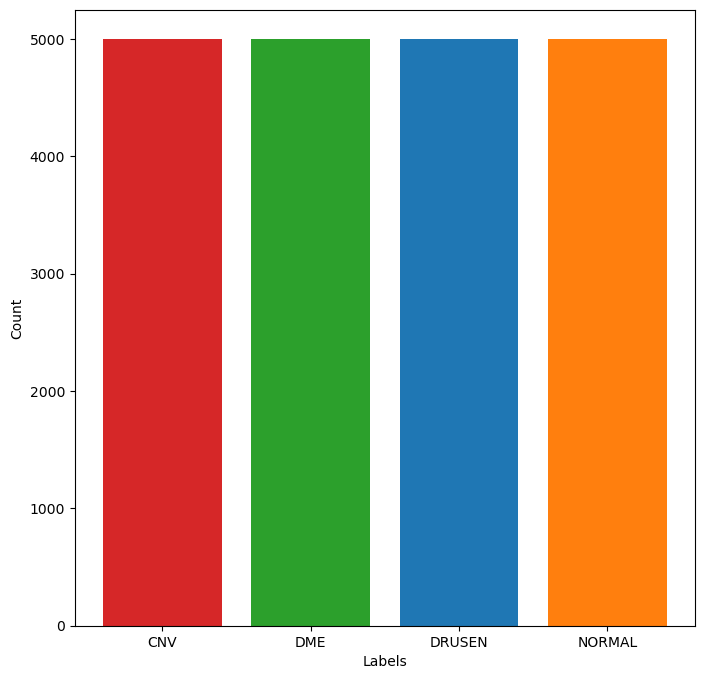

In [4]:
cnv_images = len(glob(train_data_dir + '/CNV/*.jpeg'))
dme_images = len(glob(train_data_dir + '/DME/*.jpeg'))
drusen_images = len(glob(train_data_dir + '/DRUSEN/*.jpeg'))
normal_images = len(glob(train_data_dir + '/NORMAL/*.jpeg'))
data= {'CNV': cnv_images, 'DME': dme_images, 'DRUSEN': drusen_images, 'NORMAL': normal_images}
labels = list(data.keys()) 
count = list(data.values()) 

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.bar(labels, count, color=['tab:red', 'tab:green', 'tab:blue', 'tab:orange'])
plt.axis('on')
plt.xlabel("Labels") 
plt.ylabel("Count") 
plt.savefig('labels_vs_counts.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show() 

In The training data set we have equal number of all the four samples (CNV,DME,DRUSEN,NORMAL)

### Image Histogram (Tonal Distribution)
* Histogram of a normal retina image in the train dataset:

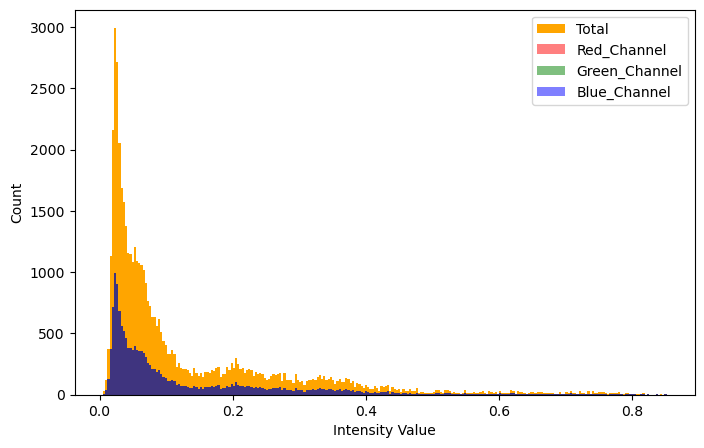

In [5]:

image = mpimg.imread(data_dir + '/train/NORMAL/NORMAL-9863816-1.jpeg')
color_img= gray2rgb(resize(image, (128, 128)))
plt.rcParams['figure.figsize'] = (8.0, 5.0)
_ = plt.hist(color_img.ravel(), bins = 256, color = 'orange', )
_ = plt.hist(color_img[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(color_img[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(color_img[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Total', 'Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.savefig('histogram.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

From the above intensity distribution we can say that the images we have has low intensity value for max number of images 

### Sample Images from the Dataset

Normal


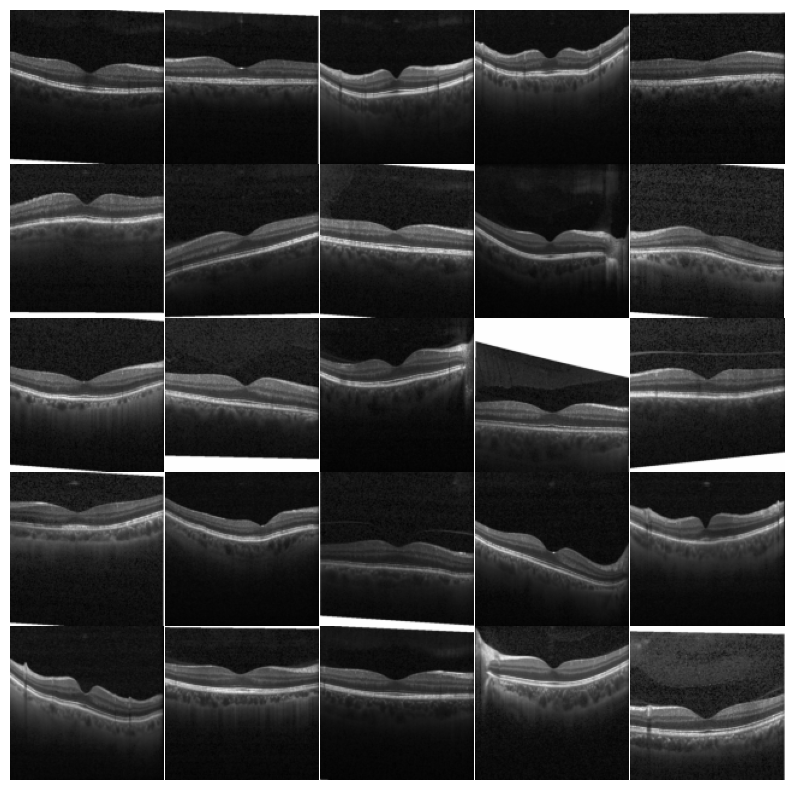

In [6]:
print("Normal")
multipleImages = glob(data_dir + '/train/NORMAL/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('normal_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Choroidal Neo-Vascularization (CNV)


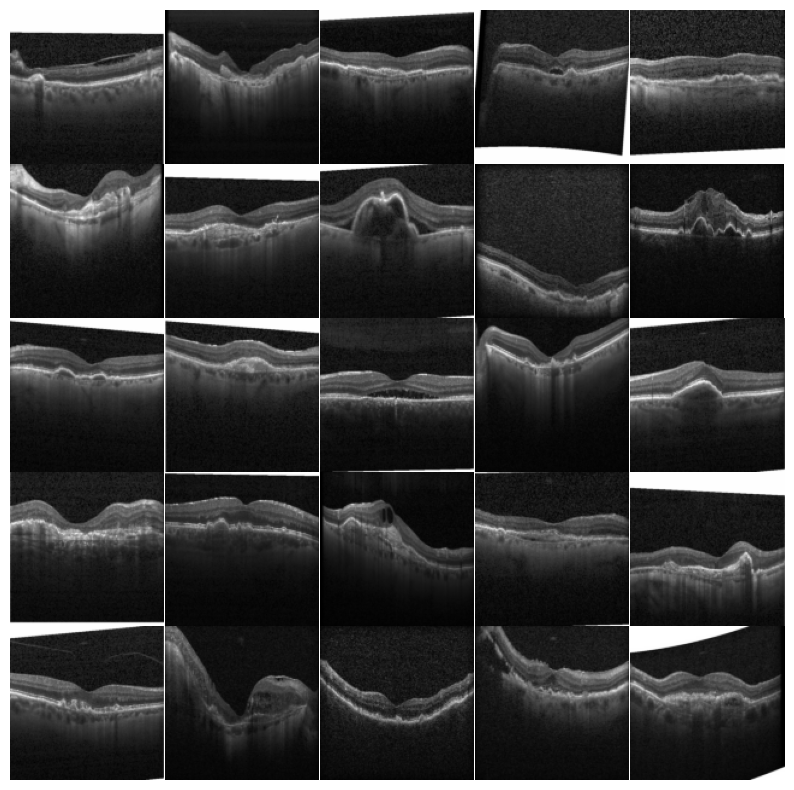

In [7]:
print("Choroidal Neo-Vascularization (CNV)")
multipleImages = glob(data_dir + '/train/CNV/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('cnv_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Diabetic Macular Edema (DME)


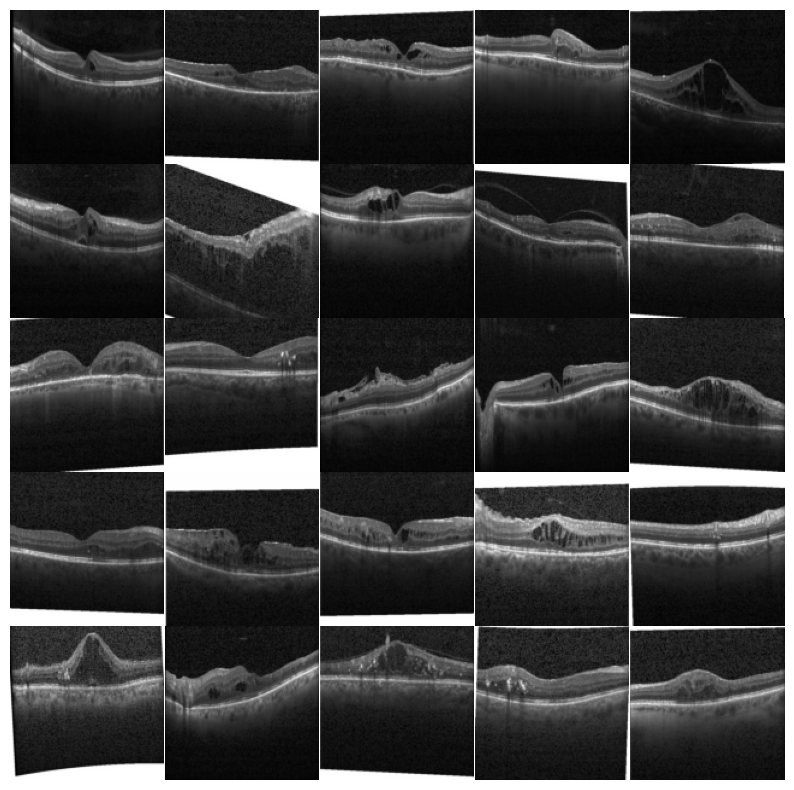

In [8]:
print("Diabetic Macular Edema (DME)") 
multipleImages = glob(data_dir + '/train/DME/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('dme_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

Drusen


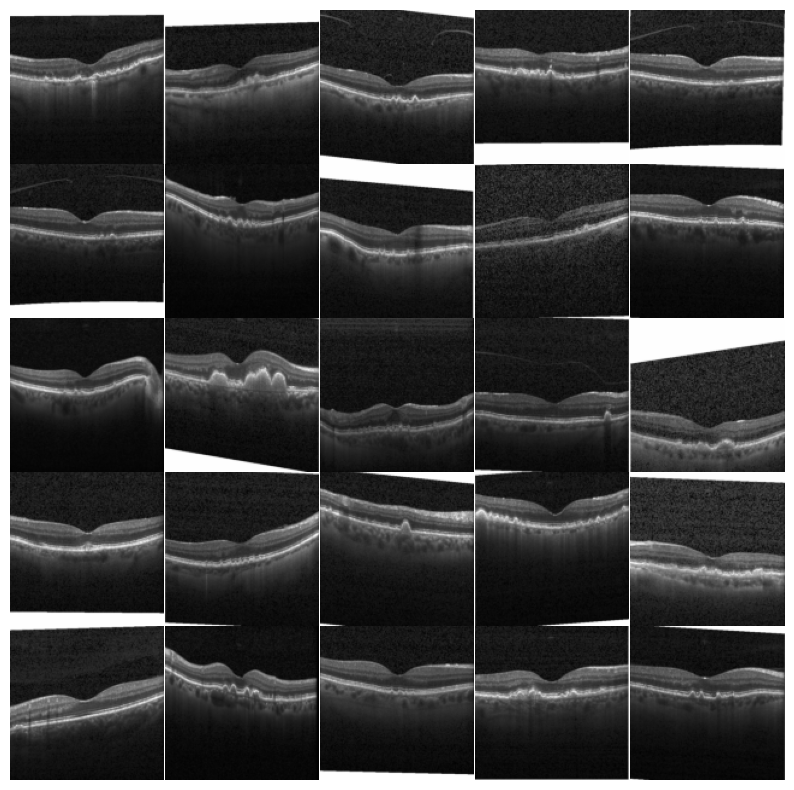

In [9]:
print("Drusen")
multipleImages = glob(data_dir + '/train/DRUSEN/**')
i = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for im in multipleImages[:25]:
    image = mpimg.imread(im)
    image_resized = resize(image, (128, 128)) 
    plt.subplot(5, 5, i+1) #.set_title(l)
    plt.imshow(gray2rgb(image_resized)); plt.axis('off')
    i += 1
plt.savefig('drusen_eye.png', transparent= False, bbox_inches= 'tight', dpi= 400)

###  Data Generators

In [10]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    zoom_range= (0.73, 0.9),
    horizontal_flip= True,
    rotation_range= 10,
    width_shift_range= 0.10,
    fill_mode= 'constant',
    height_shift_range= 0.10,   
    brightness_range= (0.55, 0.9),
)

valid_test_datagen = ImageDataGenerator(
    rescale= 1./255, 
)

In the above code to introduce variability, the augmentation includes:

1. Random zooming within a controlled range (from 73% to 90%).
2. Horizontal flipping, resulting in mirror images.
3. Random rotation of up to 10 degrees.
4. Horizontal and vertical shifting of up to 10% of image dimensions.
5. Adjustment of brightness, allowing for random alterations ranging from 55% to 90% of the original brightness.

In [11]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
) 

valid_generator = valid_test_datagen.flow_from_directory(
    val_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 1337
)

test_generator = valid_test_datagen.flow_from_directory(  
    test_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,        
    class_mode= 'categorical',
    shuffle= False, 
    
)

Found 20000 images belonging to 4 classes.
Found 4000 images belonging to 4 classes.
Found 10000 images belonging to 1 classes.


In [12]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)
nb_test_samples = len(test_generator.filenames)

###  Data Augmentation

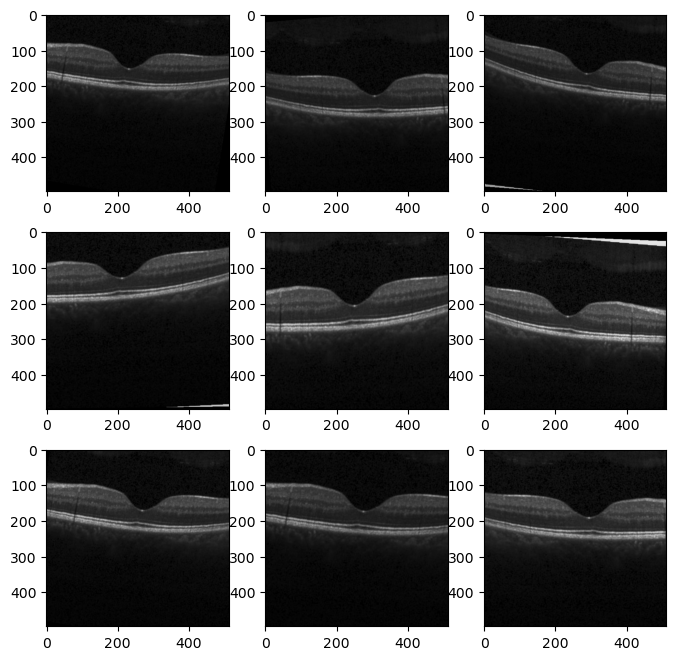

In [13]:
img = load_img("/kaggle/input/medical-image-data/train/NORMAL/NORMAL-1014715-9.jpeg")
data = img_to_array(img)
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)
plt.rcParams['figure.figsize'] = (8.0, 8.0)

for i in range(9):
	plt.subplot(330 + 1 + i)
	batch = it.next()
	image = batch[0]
	plt.imshow(image)

plt.savefig('augmented_image.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

from the above images we can observe how the input image is transformed by data augmentation.

# Model
* * Leveraging the VGG16 CNN architecture, we harness its pretrained capabilities on the 'ImageNet' dataset to excel in classification tasks.

In [14]:
vgg16 = VGG16(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
vgg16.summary()
     

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [15]:
model = Sequential()

for layer in vgg16.layers:
    model.add(layer)

for layer in model.layers:
    layer.trainable= False

model.add(Flatten(input_shape= (4, 4, 512)))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)       2

### VGG16 Architecture

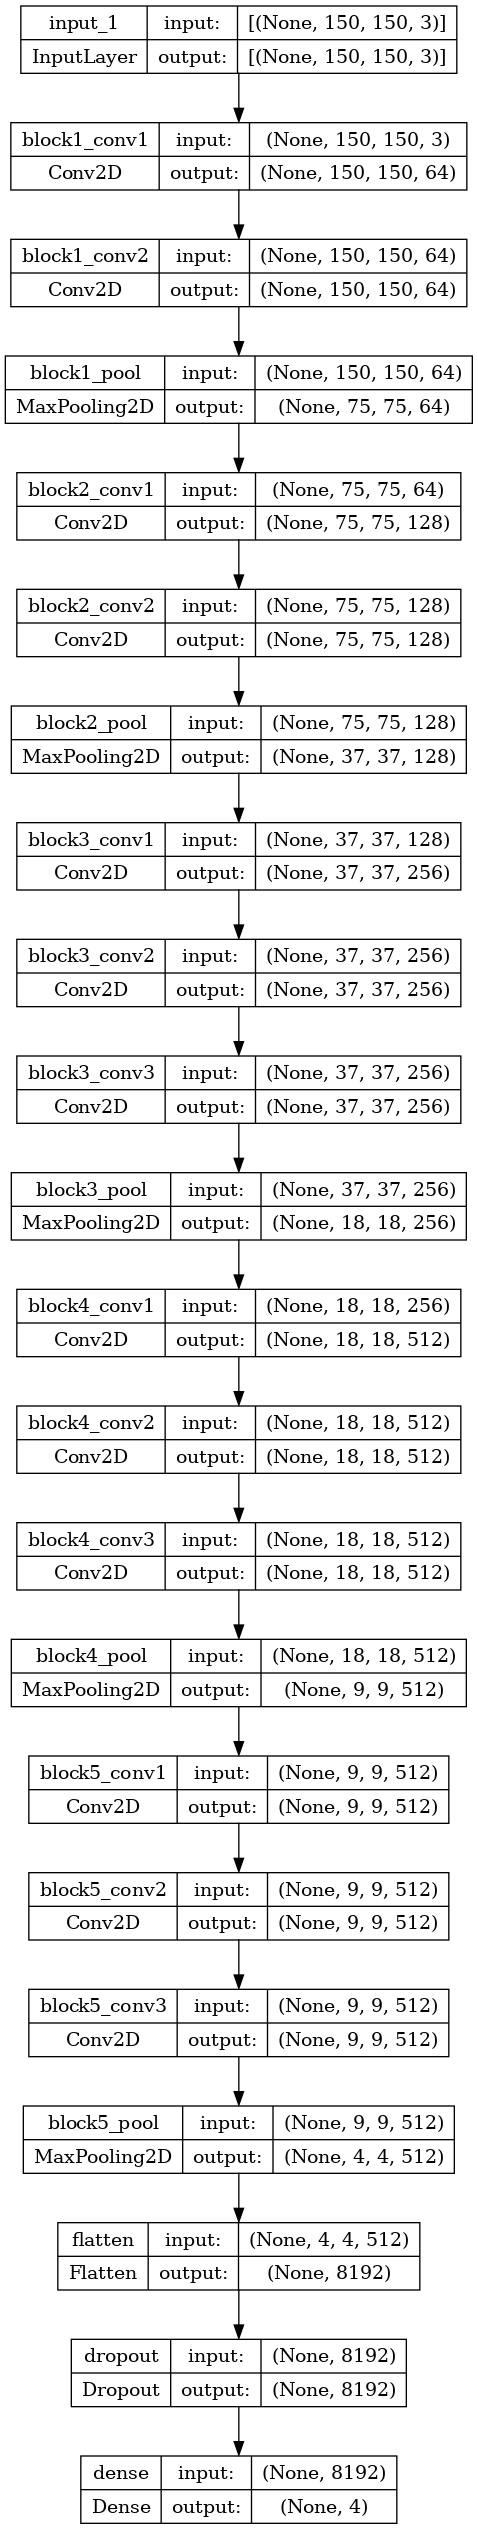

In [16]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

## Initial Model Training

In [17]:
model.compile(optimizer= keras.optimizers.Adam(lr= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [18]:
checkpoint = ModelCheckpoint(
    'baseline_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "baseline_training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]


In [19]:
history = model.fit(
    train_generator, 
    epochs = 30,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 2,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/30

Epoch 1: val_loss improved from inf to 0.68960, saving model to baseline_model.h5
625/625 - 259s - loss: 0.7587 - accuracy: 0.6979 - val_loss: 0.6896 - val_accuracy: 0.7250 - lr: 0.0010 - 259s/epoch - 415ms/step
Epoch 2/30

Epoch 2: val_loss did not improve from 0.68960
625/625 - 188s - loss: 0.6240 - accuracy: 0.7613 - val_loss: 0.8160 - val_accuracy: 0.6865 - lr: 0.0010 - 188s/epoch - 301ms/step
Epoch 3/30

Epoch 3: val_loss improved from 0.68960 to 0.67662, saving model to baseline_model.h5
625/625 - 188s - loss: 0.5975 - accuracy: 0.7698 - val_loss: 0.6766 - val_accuracy: 0.7372 - lr: 0.0010 - 188s/epoch - 302ms/step
Epoch 4/30

Epoch 4: val_loss improved from 0.67662 to 0.59067, saving model to baseline_model.h5
625/625 - 189s - loss: 0.5809 - accuracy: 0.7759 - val_loss: 0.5907 - val_accuracy: 0.7700 - lr: 0.0010 - 189s/epoch - 302ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.59067
625/625 - 185s - loss: 0.5678 - accuracy: 0.7836 - val_loss: 0.7094 - va

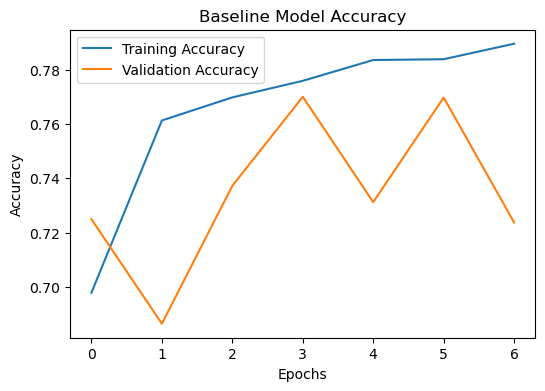

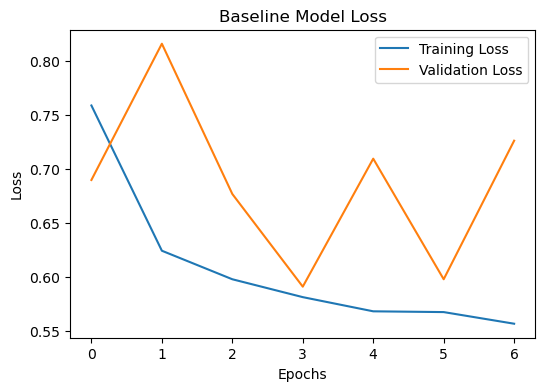

In [22]:

plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Baseline Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

plt.subplot()
plt.title('Baseline Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()
     


Unlocking Model Weights with a Decreased Learning Rate
***
* 1. We've unfrozen the model's weights.
* 2. A reduced learning rate has been applied for fine-tuning.

In [23]:
model.trainable= True
model.compile(optimizer= keras.optimizers.Adam(1e-5), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [24]:
checkpoint = ModelCheckpoint(
    'finetuned_model.h5',
    monitor='loss',
    verbose=1,
    save_best_only=True,
    mode='auto',
    save_weights_only=False,
    period=1
)

earlystop = EarlyStopping(
    monitor='loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "finetuned_training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [25]:
history_1 = model.fit(
    train_generator, 
    epochs = 10,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 2,
    callbacks = callbacks,
    shuffle = True
)

Epoch 1/10

Epoch 1: loss improved from inf to 0.44507, saving model to finetuned_model.h5
625/625 - 201s - loss: 0.4451 - accuracy: 0.8355 - val_loss: 0.4164 - val_accuracy: 0.8418 - lr: 1.0000e-05 - 201s/epoch - 321ms/step
Epoch 2/10

Epoch 2: loss improved from 0.44507 to 0.30905, saving model to finetuned_model.h5
625/625 - 189s - loss: 0.3091 - accuracy: 0.8893 - val_loss: 0.2913 - val_accuracy: 0.8955 - lr: 1.0000e-05 - 189s/epoch - 303ms/step
Epoch 3/10

Epoch 3: loss improved from 0.30905 to 0.26417, saving model to finetuned_model.h5
625/625 - 190s - loss: 0.2642 - accuracy: 0.9105 - val_loss: 0.2891 - val_accuracy: 0.8888 - lr: 1.0000e-05 - 190s/epoch - 303ms/step
Epoch 4/10

Epoch 4: loss improved from 0.26417 to 0.23269, saving model to finetuned_model.h5
625/625 - 188s - loss: 0.2327 - accuracy: 0.9207 - val_loss: 0.2747 - val_accuracy: 0.9007 - lr: 1.0000e-05 - 188s/epoch - 301ms/step
Epoch 5/10

Epoch 5: loss improved from 0.23269 to 0.21839, saving model to finetuned_mo

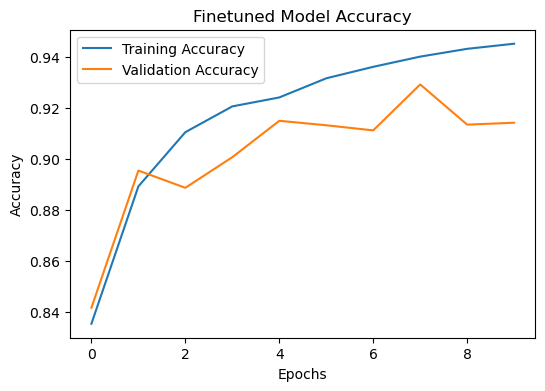

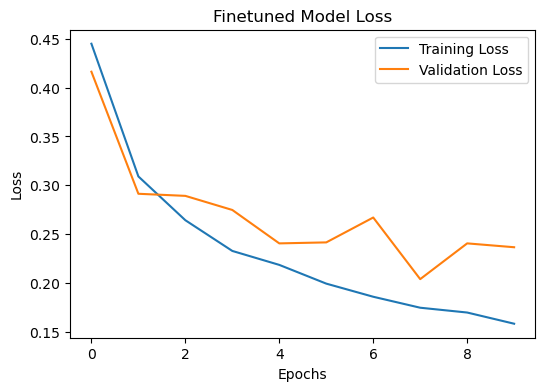

In [26]:
plt.subplot()
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.title('Finetuned Model Accuracy')
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('finetuned_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

plt.subplot()
plt.title('Finetuned Model Loss')
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('finetuned_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 400)
plt.show()

# Evaluations on Test Dataset And Visualization

In [52]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model

model = load_model('/kaggle/working/finetuned_model.h5')  

test_directory = '/kaggle/input/medical-image-data/test' 
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(128, 128),
    batch_size=1,
    shuffle=False,
    class_mode=None
)

test_filenames = test_generator.filenames

# Make predictions on the test images
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Extract class predictions for each test image
predicted_classes = np.argmax(predictions, axis=1)

# Map class indices to class labels (assuming your model was trained with class indices)
class_labels = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# Create a dictionary to map class indices to class labels
class_mapping = {i: label for i, label in enumerate(class_labels)}

# Map predicted class indices to class labels
predicted_labels = [class_mapping[i] for i in predicted_classes]

# Create a DataFrame to store the image filenames and their corresponding predicted labels
results = pd.DataFrame({'Filename': test_filenames, 'Predicted_Class': predicted_labels})

results.to_csv('test_predictions.csv', index=False)
print(results.head(10))

Found 10000 images belonging to 1 classes.
10000/10000 [==============================] - 49s 5ms/step
         Filename Predicted_Class
0      test/1.jpg             DME
1     test/10.jpg          NORMAL
2    test/100.jpg          NORMAL
3   test/1000.jpg          NORMAL
4  test/10000.jpg             DME
5   test/1001.jpg          NORMAL
6   test/1002.jpg          DRUSEN
7   test/1003.jpg          NORMAL
8   test/1004.jpg          NORMAL
9   test/1005.jpg          NORMAL


I have save the peredictied test Data in test_predictions.csv file 
the model that i have fine tuned working well with validation acuracy --- 91.45 % 
and it can be improve futher with much 

# Number of images in each class

In [55]:
import pandas as pd


df = pd.read_csv('test_predictions.csv')

class_counts = df['Predicted_Class'].value_counts()

print("Number of images in each class:")
print(class_counts)


Number of images in each class:
NORMAL    5105
DME       2937
CNV       1256
DRUSEN     702
Name: Predicted_Class, dtype: int64


Image: test/1.jpg - Predicted Class: DME


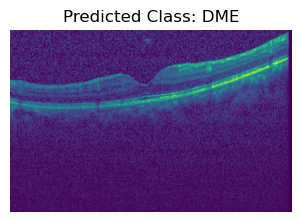

Image: test/10.jpg - Predicted Class: NORMAL


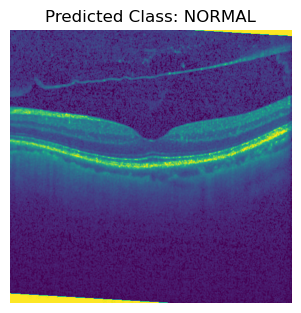

Image: test/100.jpg - Predicted Class: NORMAL


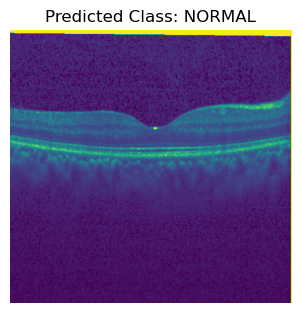

Image: test/1000.jpg - Predicted Class: NORMAL


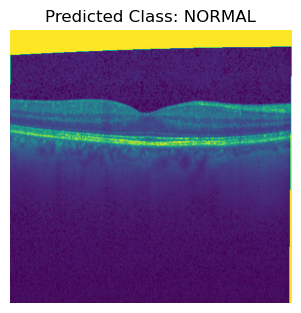

Image: test/10000.jpg - Predicted Class: DME


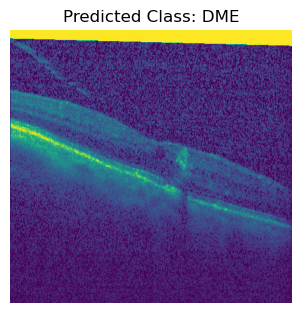

In [61]:

import matplotlib.pyplot as plt
from PIL import Image

# Define a function to display test images with their predicted classes
def display_images_with_predictions(results, num_images=5):
    for i in range(num_images):
        filename = results['Filename'][i]
        predicted_class = results['Predicted_Class'][i]

        # Load and display the test image
        img = Image.open(os.path.join(test_directory, filename))
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Predicted Class: {predicted_class}')

        # Print the predicted class label
        print(f"Image: {filename} - Predicted Class: {predicted_class}")

        plt.show()

# Call the function to display a few test images with predictions
display_images_with_predictions(results, num_images=5)


# Conclusion

I have trained the model with 2 different learning rate lr1 = 0.001 and lr2 = 1e-5 
fist one did't provied good validation accuracy but second model provide a good validation accuracy of ~ 91 % then i have used <finetuned_model.h5> model and run that model on test data. 

References
1.  github 
2.  kaggle
3.  google 